# W266 Final Project

Authors: Satheesh Joseph, Catherine Mou, Yi Zhang

# Part 1: Downloading and preparing the data

We acquired the dataset from the researchers in the form of Sqlite `.db` files.

In [1]:
# Imports
import tensorflow_text as text 
import os, sys, re, json, time, unittest
import itertools, collections
from importlib import reload
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime

import numpy as np
from scipy import stats
import pandas as pd
import sqlite3
import unicodedata
import nltk

import tensorflow as tf
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, InputLayer, Embedding
from tensorflow.keras.layers import TextVectorization
import tensorflow_text as text  # Registers the ops.

from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_hub as hub

import tensorflow.keras as keras
from tensorflow.python.keras import utils

In [2]:
# Download the files if they're not here
if 'data' not in os.listdir('.') or not os.listdir('data'):
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpHotelData.db -P data/')
    os.system('wget https://storage.googleapis.com/mids-w266-final-project-data/yelpResData.db -P data/')
    print('Data downloaded successfully!')
else:
    print('Already downloaded data')

Already downloaded data


In [3]:
# Load data from the database
con = sqlite3.connect('data/yelpHotelData.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('review',), ('sqlite_stat1',), ('sqlite_stat2',), ('reviewer',), ('hotel',)]


In [4]:
# Reading from the hotels database
hotels_db = sqlite3.connect("data/yelpHotelData.db")
hotels = pd.read_sql_query("SELECT * FROM hotel", hotels_db)
hotel_reviews = pd.read_sql_query("SELECT * FROM review WHERE flagged in ('Y', 'N')", hotels_db)
hotel_reviewers = pd.read_sql_query("SELECT * FROM reviewer", hotels_db)

print(f'The data set contains {len(hotel_reviews)} reviews, and {len(hotel_reviewers)} reviewers')

The data set contains 5858 reviews, and 5123 reviewers


In [5]:
# Data Cleaning
hotel_reviews['reviewContent'] = hotel_reviews['reviewContent'].apply(lambda x: unicodedata.normalize('NFKD', x))
hotel_reviews['date'] = hotel_reviews['date'].apply(lambda x: datetime.datetime.strptime(x.strip().split(' ')[-1], '%m/%d/%Y'))


In [6]:
# Split data according to the research paper, i.e. balanced new reviews after 2012-01-01
hotel_X_test = hotel_reviews[hotel_reviews['date'] >= datetime.datetime(2012, 1, 1)]
hotel_X_test = hotel_X_test.sort_values('date', ignore_index=True).groupby('reviewerID', as_index=False).first()
hotel_X_test_positive = hotel_X_test[hotel_X_test['flagged'] == 'Y']
hotel_X_test_negative = hotel_X_test[hotel_X_test['flagged'] == 'N']
hotel_X_test_balanced = pd.concat([hotel_X_test_positive, hotel_X_test_negative.sample(n=len(hotel_X_test_positive))], ignore_index=True)
hotel_X_test = hotel_X_test_balanced.sample(frac=1)
hotel_y_test = hotel_X_test['flagged'] == 'Y'
hotel_X_train = hotel_reviews[hotel_reviews['date'] < datetime.datetime(2012, 1, 1)]
hotel_y_train = hotel_X_train['flagged'] == 'Y'


# Part 2: Exploratory Data Analysis

In [7]:
hotel_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4536 entries, 0 to 5857
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4536 non-null   datetime64[ns]
 1   reviewID       4536 non-null   object        
 2   reviewerID     4536 non-null   object        
 3   reviewContent  4536 non-null   object        
 4   rating         4536 non-null   int64         
 5   usefulCount    4536 non-null   int64         
 6   coolCount      4536 non-null   int64         
 7   funnyCount     4536 non-null   int64         
 8   flagged        4536 non-null   object        
 9   hotelID        4536 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 389.8+ KB


In [8]:
reviews = hotel_X_train
reviews.groupby('reviewerID').agg({"usefulCount": np.sum, 
                                   "coolCount": np.sum, 
                                   "funnyCount": np.sum}).sort_values(by=['usefulCount'], ascending=False)
print(reviews[reviews['reviewerID'] == 'w-w-k-QXosIKQ8HQVwU6IQ']['reviewContent'].iloc[0])

***While the rooms are small, Hotel Felix is a nice hotel with modern and fresh decor, comfortable beds, clean rooms, good room temperature, and good showers; all these advantages plus their very good location make this one to definitely consider if you can get a competitive room rate*** Hotel Felix is an eco-friendly (Silver LEED certification) boutique hotel that has a convenient location in River North.  It is close to one of the subway lines as well as many well-known Chicago restaurants (Ria, Graham Elliot, Rick Bayless' spots) and The Magnificent Mile.  A lot of Chicago is walk-able and staying at Hotel Felix makes the walking part even easier. The hotel exterior (an older, renovated building) stands out with its huge (but not garish) sign.  The inside of the hotel is small--from the elevators to the lobby to the rooms.  I thought my room, which was on the top floor was actually not too small (maybe bigger than what some of the other reviewers had) and provided a decent view of s

In [9]:
reviews.groupby('flagged').agg('sum')

,rating,usefulCount,coolCount,funnyCount
flagged,,,,
N,14188,5020,2641,2254
Y,1817,0,0,0


,date,reviewID,reviewerID,reviewContent,usefulCount,coolCount,funnyCount,flagged,hotelID
rating,,,,,,,,,
1,283,283,283,283,283,283,283,283,283
2,459,459,459,459,459,459,459,459,459
3,802,802,802,802,802,802,802,802,802
4,1574,1574,1574,1574,1574,1574,1574,1574,1574
5,857,857,857,857,857,857,857,857,857


(array([ 283.,    0.,  459.,    0.,    0.,  802.,    0., 1574.,    0.,
         857.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

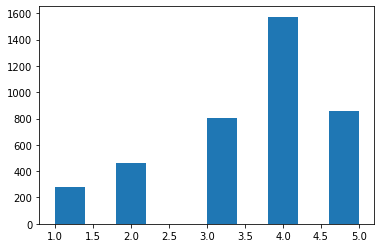

In [10]:
trueReviews = reviews[reviews['flagged'] == 'N']
fakeReviews = reviews[reviews['flagged'] == 'Y']
display(trueReviews.groupby('rating').agg('count'))
plt.hist(x=trueReviews.rating, bins=10)

,date,reviewID,reviewerID,reviewContent,usefulCount,coolCount,funnyCount,flagged,hotelID
rating,,,,,,,,,
1,125,125,125,125,125,125,125,125,125
2,82,82,82,82,82,82,82,82,82
3,58,58,58,58,58,58,58,58,58
4,126,126,126,126,126,126,126,126,126
5,170,170,170,170,170,170,170,170,170


(array([125.,   0.,  82.,   0.,   0.,  58.,   0., 126.,   0., 170.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

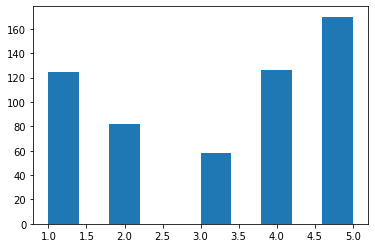

In [11]:
display(fakeReviews.groupby('rating').agg('count'))
plt.hist(x=fakeReviews.rating, bins=10)

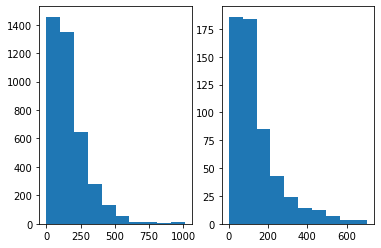

In [12]:
plt.subplot(1, 2, 1)
plt.hist(x = trueReviews['reviewContent'].str.count(' ') + 1)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviews['reviewContent'].str.count(' ') + 1)
plt.show()

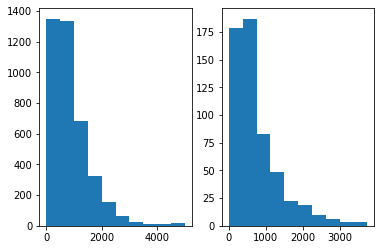

In [13]:
plt.subplot(1, 2, 1)
plt.hist(x = trueReviews['reviewContent'].str.count('.') + 1)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviews['reviewContent'].str.count('.') + 1)
plt.show()

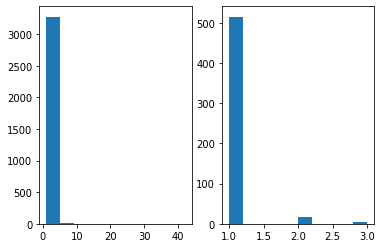

In [14]:
trueReviewerCounts = trueReviews.groupby(['reviewerID']).size().reset_index(name='counts')
fakeReviewerCounts = fakeReviews.groupby(['reviewerID']).size().reset_index(name='counts')


plt.subplot(1, 2, 1)
plt.hist(x = trueReviewerCounts['counts'], bins=10)
plt.subplot(1, 2, 2)
plt.hist(x = fakeReviewerCounts['counts'], bins=10)
plt.show()


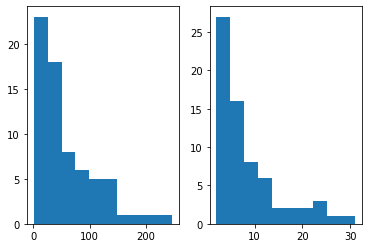

In [15]:
trueRestReviewCounts = trueReviews.groupby(['hotelID']).size().reset_index(name='counts')
fakeRestReviewCounts = fakeReviews.groupby(['hotelID']).size().reset_index(name='counts')


plt.subplot(1, 2, 1)
plt.hist(x = trueRestReviewCounts['counts'], bins=10)
plt.subplot(1, 2, 2)
plt.hist(x = fakeRestReviewCounts['counts'], bins=10)
plt.show()


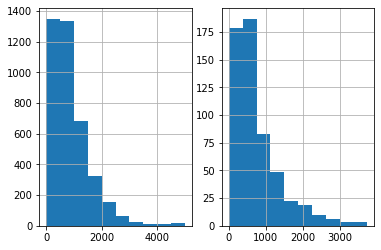

In [16]:
plt.subplot(1, 2, 1)
trueReviews['reviewContent'].str.len().hist()
plt.subplot(1, 2, 2)
fakeReviews['reviewContent'].str.len().hist()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yizhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


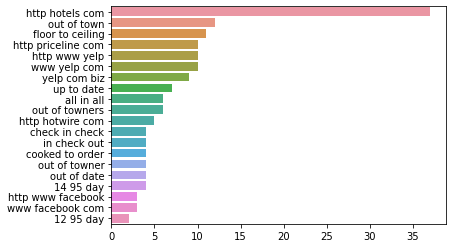

In [17]:
# Code Snippet for Top N-grams Barchart

import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

nltk.download('stopwords')

def plot_top_ngrams_barchart(text, n=2):
    synthetic = {'gmail', 'they', 'http', 'www'}
    stop=set(stopwords.words('english')) | synthetic
    new= text.str.split()
    new= new.values.tolist()
    corpus=[word for i in new for word in i if word.lower() not in stop]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(corpus,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    

plot_top_ngrams_barchart(trueReviews['reviewContent'],3)

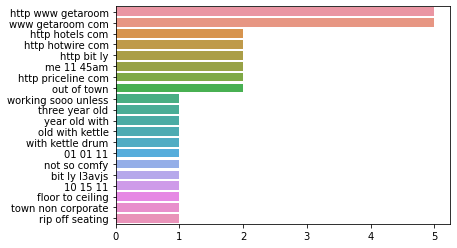

In [18]:
plot_top_ngrams_barchart(fakeReviews['reviewContent'],3)

In [19]:
fake_df = hotel_reviews[hotel_reviews['flagged'] == 'Y']["reviewerID"].to_frame()
true_df = hotel_reviews[hotel_reviews['flagged'] == 'N']["reviewerID"].to_frame()
print("Fake Reviewers " + str(len(fake_df["reviewerID"].unique())))
print("True Reviewers " + str(len(true_df["reviewerID"].unique())))
print("True and Fake Reviewers " + str(len(list(set(fake_df["reviewerID"].unique()) & set(true_df["reviewerID"].unique())))))

Fake Reviewers 751
True Reviewers 4277
True and Fake Reviewers 0


In [20]:
full_rest_df = pd.merge(hotel_reviews, hotel_reviewers, on="reviewerID")
fake_df = full_rest_df[full_rest_df['flagged'] == 'Y']["firstCount"]
true_df = full_rest_df[full_rest_df['flagged'] == 'N']["firstCount"]
print("Fake stats Counts " + str(fake_df.count()) + str(" Sum ") + str(fake_df.sum()))
print("True stats Counts " + str(true_df.count()) + str(" Sum ") + str(true_df.sum()))

Fake stats Counts 777 Sum 486
True stats Counts 5072 Sum 144161


# Part 3: Model Training

## Preparing for the word embeddings

In [25]:
# GloVe Embeddings
# Download the GloVe embeddings
if 'embedding' not in os.listdir('.') or not os.listdir('embedding'):
    os.system('wget http://nlp.stanford.edu/data/glove.6B.zip -P embedding/')
    os.system('cd embedding && unzip glove.6B.zip')
    print('Data the GloVe embedding successfully!')
else:
    print('Already downloaded the embedding')
    
# Use the 100 dimensional GloVe embedding
path_to_glove_file = "./embedding/glove.6B.300d.txt"

glove_dimension = 300
glove_embedding_map = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embedding_map[word] = coefs

print("Found %s word vectors." % len(glove_embedding_map))

def get_glove_embedding(word):
    return glove_embedding_map.get(word.strip(), None)


Already downloaded the embedding
Found 400000 word vectors.


In [22]:
# Pre-trained Elmo
elmo = hub.load("./elmo_3")

def get_elmo_embedding(words):
    return elmo.signatures['default'](tf.constant(words))['elmo']


2021-11-29 21:51:56.593776: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preparing for the different training sets

In [23]:
# Set 1: original imbalanced set
hotel_X_train_1 = hotel_X_train.copy()
hotel_y_train_1 = hotel_X_train_1['flagged'] == 'Y'
print('training set 1 value counts:')
print(hotel_X_train_1['flagged'].value_counts())

# Prepping for data balancing
hotel_X_train_positive = hotel_X_train[hotel_X_train['flagged'] == 'Y']
hotel_X_train_negative = hotel_X_train[hotel_X_train['flagged'] == 'N']

hotel_num_positive_samples = len(hotel_X_train_positive)
hotel_num_negative_samples = len(hotel_X_train_negative)

# Train set 2: Under sampling some negative training samples
hotel_X_sampled_negatives = hotel_X_train_negative.sample(n=hotel_num_positive_samples).reset_index(drop=True)

hotel_X_train_2 = pd.concat([hotel_X_train_positive, hotel_X_sampled_negatives], ignore_index=True).sample(frac=1)
hotel_y_train_2 = hotel_X_train_2['flagged'] == 'Y'
print('training set 2 value counts:')
print(hotel_X_train_2['flagged'].value_counts())

# Train set 3: Over sampling some positive training samples
hotel_X_sampled_positives = hotel_X_train_positive.sample(n=hotel_num_negative_samples, replace=True).reset_index(drop=True)

hotel_X_train_3 = pd.concat([hotel_X_sampled_positives, hotel_X_train_negative], ignore_index=True).sample(frac=1)
hotel_y_train_3 = hotel_X_train_3['flagged'] == 'Y'
print('training set 3 value counts:')
print(hotel_X_train_3['flagged'].value_counts())


# Train set 4: Including generated fake reviews
# Load in previous generated fake reviews
with open('final_GAN.txt') as f:
    lines = f.read().splitlines()
    lines = [l for l in lines if l]
    hotel_X_train_positive_generated = pd.DataFrame({'reviewContent':lines, 'flagged': 'Y'})

# Add generated fake reviews into the training set

hotel_X_train_all_positive = pd.concat([hotel_X_train_positive, hotel_X_train_positive_generated], ignore_index=True)

num_samples = min(len(hotel_X_train_all_positive), len(hotel_X_train_negative))
hotel_X_train_all_positive_sampled = hotel_X_train_all_positive.sample(n=num_samples)
hotel_X_train_negative_sampled = hotel_X_train_negative.sample(n=num_samples)

hotel_X_train_4 = pd.concat([hotel_X_train_all_positive_sampled, hotel_X_train_negative_sampled], ignore_index=True).sample(frac=1)
hotel_y_train_4 = hotel_X_train_4['flagged'] == 'Y'
print('training set 4 value counts:')
print(hotel_X_train_4['flagged'].value_counts())


training set 1 value counts:
N    3975
Y     561
Name: flagged, dtype: int64
training set 2 value counts:
Y    561
N    561
Name: flagged, dtype: int64
training set 3 value counts:
Y    3975
N    3975
Name: flagged, dtype: int64
training set 4 value counts:
Y    2535
N    2535
Name: flagged, dtype: int64


## Model 1: GloVe Embedding + Plain LSTM

In [26]:
def build_model_1(X_train, y_train, X_test, y_test, num_units, num_epochs, sequence_length):
    
    # First layer, vectorizing the word input
    m1_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m1_vectorizer.adapt(X_train['reviewContent'].to_numpy())
    m1_voc = m1_vectorizer.get_vocabulary()

    print(f"Model 1: vocabulary size is {len(m1_voc)}")

    # Build + Lock in the Embedding layer from GloVe
    # Ref: https://keras.io/examples/nlp/pretrained_word_embeddings/
    hits = 0
    misses = 0
    num_words = len(m1_voc)

    # Prepare embedding matrix
    m1_embedding_matrix = np.zeros((num_words, glove_dimension))
    for i, word in enumerate(m1_voc):
        embedding_vector = get_glove_embedding(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            m1_embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    m1_embedding_layer = Embedding(
        num_words,
        glove_dimension,
        embeddings_initializer=tf.keras.initializers.Constant(m1_embedding_matrix),
        trainable=False,
    )

    # Vectorize the input
    X_train_ready = m1_vectorizer(X_train['reviewContent']).numpy()
    X_test_ready = m1_vectorizer(X_test['reviewContent']).numpy()
    print(f'training set shape: {X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_1')
    model.add(m1_embedding_layer)
    model.add(LSTM(num_units))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(X_train_ready, y_train, epochs=num_epochs)

    # Evaluate on the test set
    y_predicted = model.predict(X_test_ready)
    print(classification_report(y_predicted > 0.5, y_test))
    print('Test set class distribution')
    print(X_test['flagged'].value_counts() / len(X_test))
    return model.evaluate(X_test_ready, y_test, return_dict=True)


In [27]:
# Grid search for evaluation
for i in [1,2,3,4]:
    print(f"+++++++++++training on data set {i}+++++++++++++")
    X_train = eval(f'hotel_X_train_{i}')
    y_train = eval(f'hotel_y_train_{i}')
    best = 0
    for num_units in [8, 16, 32, 64]:
        for sequence_length in [100, 200, 350]:
            for epochs in [10, 20]:
                print('---------------------------------------------------------------------------')
                print(f"Start training with num_units={num_units} sequence_length={sequence_length}")
                acc = build_model_1(X_train, y_train, hotel_X_test, hotel_y_test, num_units, epochs, sequence_length)['accuracy']
                print(f"Accuracy for this run is: {acc}")
                best = max(best, acc)
                
    print(f"!!!!!!!!!! Best result for data set {i} is {best}")


+++++++++++training on data set 1+++++++++++++
---------------------------------------------------------------------------
Start training with num_units=8 sequence_length=100
Model 1: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 100)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         6709200   
                                                                 
 lstm (LSTM)                 (None, 8)                 9888      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 6,719,097
Trainable params: 9,897
Non-trainable params: 6,709,200
_________________________________________________________________
None
Epoch 1/10
142/142 [=======

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
14/14 [==============================] - 1s 9ms/step - loss: 1.1107 - accuracy: 0.5000
Accuracy for this run is: 0.5
---------------------------------------------------------------------------
Start training with num_units=8 sequence_length=200
Model 1: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 200)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         6709200   
                                   

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
14/14 [==============================] - 1s 18ms/step - loss: 1.0988 - accuracy: 0.5000
Accuracy for this run is: 0.5
---------------------------------------------------------------------------
Start training with num_units=8 sequence_length=350
Model 1: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 350)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         6709200   
                                  

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
14/14 [==============================] - 1s 27ms/step - loss: 1.1259 - accuracy: 0.5000
Accuracy for this run is: 0.5
---------------------------------------------------------------------------
Start training with num_units=16 sequence_length=100
Model 1: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 100)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         6709200   
                                 

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
14/14 [==============================] - 1s 17ms/step - loss: 1.1753 - accuracy: 0.5000
Accuracy for this run is: 0.5
---------------------------------------------------------------------------
Start training with num_units=16 sequence_length=350
Model 1: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 350)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 300)         6709200   
                                 

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
14/14 [==============================] - 1s 29ms/step - loss: 1.1048 - accuracy: 0.5000
Accuracy for this run is: 0.5
---------------------------------------------------------------------------
Start training with num_units=32 sequence_length=100
Model 1: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 100)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 300)         6709200   
                                 

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
14/14 [==============================] - 1s 21ms/step - loss: 1.4091 - accuracy: 0.5000
Accuracy for this run is: 0.5
---------------------------------------------------------------------------
Start training with num_units=32 sequence_length=350
Model 1: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 350)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 300)         6709200   
                                 

14/14 [==============================] - 1s 18ms/step - loss: 0.7194 - accuracy: 0.5046
Accuracy for this run is: 0.5046296119689941
---------------------------------------------------------------------------
Start training with num_units=8 sequence_length=350
Model 1: vocabulary size is 10644
Converted 8710 words (1934 misses)
training set shape: (1122, 350)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 300)         3193200   
                                                                 
 lstm_11 (LSTM)              (None, 8)                 9888      
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,203,097
Trainable params: 9,897
Non-trainable params: 3,193,200
_____________

36/36 [==============================] - 6s 98ms/step - loss: 0.6927 - accuracy: 0.4973
Epoch 2/10
36/36 [==============================] - 4s 98ms/step - loss: 0.6891 - accuracy: 0.5205
Epoch 3/10
36/36 [==============================] - 4s 97ms/step - loss: 0.6857 - accuracy: 0.5205
Epoch 4/10
36/36 [==============================] - 3s 96ms/step - loss: 0.6806 - accuracy: 0.5267
Epoch 5/10
36/36 [==============================] - 3s 97ms/step - loss: 0.6811 - accuracy: 0.5214
Epoch 6/10
36/36 [==============================] - 3s 97ms/step - loss: 0.6720 - accuracy: 0.5357
Epoch 7/10
36/36 [==============================] - 3s 96ms/step - loss: 0.6658 - accuracy: 0.5089
Epoch 8/10
36/36 [==============================] - 3s 97ms/step - loss: 0.6648 - accuracy: 0.5187
Epoch 9/10
36/36 [==============================] - 4s 99ms/step - loss: 0.6593 - accuracy: 0.5419
Epoch 10/10
36/36 [==============================] - 4s 97ms/step - loss: 0.6562 - accuracy: 0.5428
              precis

36/36 [==============================] - 4s 100ms/step - loss: 0.6722 - accuracy: 0.5374
Epoch 6/10
36/36 [==============================] - 4s 99ms/step - loss: 0.6624 - accuracy: 0.5303
Epoch 7/10
36/36 [==============================] - 4s 100ms/step - loss: 0.6510 - accuracy: 0.5481
Epoch 8/10
36/36 [==============================] - 4s 101ms/step - loss: 0.6467 - accuracy: 0.5508
Epoch 9/10
36/36 [==============================] - 4s 101ms/step - loss: 0.6450 - accuracy: 0.5321
Epoch 10/10
36/36 [==============================] - 4s 101ms/step - loss: 0.6468 - accuracy: 0.5561
              precision    recall  f1-score   support

       False       0.09      0.62      0.16        32
        True       0.94      0.51      0.66       400

    accuracy                           0.52       432
   macro avg       0.52      0.57      0.41       432
weighted avg       0.88      0.52      0.63       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
14/14 [=

249/249 [==============================] - 25s 99ms/step - loss: 0.6364 - accuracy: 0.5366
Epoch 8/10
249/249 [==============================] - 24s 98ms/step - loss: 0.6353 - accuracy: 0.5481
Epoch 9/10
249/249 [==============================] - 25s 101ms/step - loss: 0.6318 - accuracy: 0.5528
Epoch 10/10
249/249 [==============================] - 25s 102ms/step - loss: 0.6292 - accuracy: 0.5555
              precision    recall  f1-score   support

       False       0.17      0.62      0.26        58
        True       0.90      0.52      0.66       374

    accuracy                           0.53       432
   macro avg       0.53      0.57      0.46       432
weighted avg       0.80      0.53      0.60       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
14/14 [==============================] - 1s 33ms/step - loss: 0.7701 - accuracy: 0.5324
Accuracy for this run is: 0.5324074029922485
----------------------------------------------------------------

249/249 [==============================] - 25s 101ms/step - loss: 0.6328 - accuracy: 0.5418
              precision    recall  f1-score   support

       False       0.10      0.56      0.17        39
        True       0.92      0.51      0.65       393

    accuracy                           0.51       432
   macro avg       0.51      0.54      0.41       432
weighted avg       0.85      0.51      0.61       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
14/14 [==============================] - 1s 31ms/step - loss: 0.8286 - accuracy: 0.5116
Accuracy for this run is: 0.5115740895271301
---------------------------------------------------------------------------
Start training with num_units=32 sequence_length=100
Model 1: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (7950, 100)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Par

14/14 [==============================] - 1s 39ms/step - loss: 0.7918 - accuracy: 0.5162
Accuracy for this run is: 0.5162037014961243
!!!!!!!!!! Best result for data set 3 is 0.5810185074806213
+++++++++++training on data set 4+++++++++++++
---------------------------------------------------------------------------
Start training with num_units=8 sequence_length=100
Model 1: vocabulary size is 21015
Converted 15322 words (5693 misses)
training set shape: (5070, 100)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, None, 300)         6304500   
                                                                 
 lstm_27 (LSTM)              (None, 8)                 9888      
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                   

Model 1: vocabulary size is 21015
Converted 15322 words (5693 misses)
training set shape: (5070, 100)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, None, 300)         6304500   
                                                                 
 lstm_30 (LSTM)              (None, 16)                20288     
                                                                 
 dense_30 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,324,805
Trainable params: 20,305
Non-trainable params: 6,304,500
_________________________________________________________________
None
Epoch 1/10
159/159 [==============================] - 6s 28ms/step - loss: 0.6890 - accuracy: 0.5337
Epoch 2/10
159/159 [==============================] - 4s 28ms/step - loss: 0.6682 - accuracy: 0.5862

159/159 [==============================] - 7s 30ms/step - loss: 0.6856 - accuracy: 0.5479
Epoch 2/10
159/159 [==============================] - 5s 29ms/step - loss: 0.6589 - accuracy: 0.5941
Epoch 3/10
159/159 [==============================] - 5s 30ms/step - loss: 0.6207 - accuracy: 0.6446
Epoch 4/10
159/159 [==============================] - 5s 31ms/step - loss: 0.5719 - accuracy: 0.6897
Epoch 5/10
159/159 [==============================] - 5s 32ms/step - loss: 0.5157 - accuracy: 0.7497
Epoch 6/10
159/159 [==============================] - 5s 32ms/step - loss: 0.4570 - accuracy: 0.7809
Epoch 7/10
159/159 [==============================] - 5s 33ms/step - loss: 0.3982 - accuracy: 0.8144
Epoch 8/10
159/159 [==============================] - 5s 33ms/step - loss: 0.3574 - accuracy: 0.8373
Epoch 9/10
159/159 [==============================] - 5s 33ms/step - loss: 0.3333 - accuracy: 0.8465
Epoch 10/10
159/159 [==============================] - 5s 33ms/step - loss: 0.2727 - accuracy: 0.8830


## Model 2: Bidirectional LSTM + Dense layers

In [28]:
def build_model_2(X_train, y_train, X_test, y_test, num_units, num_epochs, sequence_length):  
    # For model 2, have to re-do the embedding again:
    m2_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m2_vectorizer.adapt(X_train['reviewContent'].to_numpy())
    m2_voc = m2_vectorizer.get_vocabulary()
    print(f"Model 2: vocabulary size is {len(m2_voc)}")

    # Build + Lock in the Embedding layer from GloVe again
    hits = 0
    misses = 0
    num_words = len(m2_voc)

    # Prepare embedding matrix
    m2_embedding_matrix = np.zeros((num_words, glove_dimension))
    for i, word in enumerate(m2_voc):
        embedding_vector = get_glove_embedding(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            m2_embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    m2_embedding_layer = Embedding(
        num_words,
        glove_dimension,
        embeddings_initializer=tf.keras.initializers.Constant(m2_embedding_matrix),
        trainable=False,
    )

    # Vectorize the input
    X_train_ready = m2_vectorizer(X_train['reviewContent']).numpy()
    X_test_ready = m2_vectorizer(X_test['reviewContent']).numpy()
    print(f'training set shape: {X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_2')
    model.add(m2_embedding_layer)
    model.add(Bidirectional(LSTM(num_units)))
    model.add(Dense(num_units//2, activation='relu'))
    model.add(Dense(num_units//4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(X_train_ready, y_train, epochs=num_epochs)

    # Evaluate on the test set
    y_predicted_test = model.predict(X_test_ready)
    print(classification_report(y_predicted_test > 0.5, y_test))
    print('Test set class distribution')
    print(X_test['flagged'].value_counts() / len(X_test))
    return model.evaluate(X_test_ready, y_test, return_dict=True)


In [ ]:
# Grid search for evaluation
for i in [1,2,3,4]:
    print(f"+++++++++++training on data set {i}+++++++++++++")
    X_train = eval(f'hotel_X_train_{i}')
    y_train = eval(f'hotel_y_train_{i}')
    best = 0
    for num_units in [8, 16, 32, 64]:
        for sequence_length in [100, 200, 350]:
            for epochs in [10, 20]:
                print('---------------------------------------------------------------------------')
                print(f"Start training with num_units={num_units} sequence_length={sequence_length}")
                acc = build_model_2(X_train, y_train, hotel_X_test, hotel_y_test, num_units, epochs, sequence_length)['accuracy']
                print(f"Accuracy for this run is: {acc}")
                best = max(best, acc)
                
    print(f"!!!!!!!!!! Best result for data set {i} is {best}")


+++++++++++training on data set 1+++++++++++++
---------------------------------------------------------------------------
Start training with num_units=8 sequence_length=100
Model 2: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 100)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_72 (Embedding)    (None, None, 300)         6709200   
                                                                 
 bidirectional_36 (Bidirecti  (None, 16)               19776     
 onal)                                                           
                                                                 
 dense_144 (Dense)           (None, 4)                 68        
                                                                 
 dense_145 (Dense)           (None, 2)                 10        
                                              

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
14/14 [==============================] - 5s 14ms/step - loss: 0.8358 - accuracy: 0.5000
Accuracy for this run is: 0.5
---------------------------------------------------------------------------
Start training with num_units=8 sequence_length=100
Model 2: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 100)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_73 (Embedding)    (None, None, 300)         6709200   
                                  

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
14/14 [==============================] - 1s 28ms/step - loss: 0.8362 - accuracy: 0.5000
Accuracy for this run is: 0.5
---------------------------------------------------------------------------
Start training with num_units=8 sequence_length=200
Model 2: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 200)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_75 (Embedding)    (None, None, 300)         6709200   
                                  

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
14/14 [==============================] - 1s 30ms/step - loss: 1.0115 - accuracy: 0.5000
Accuracy for this run is: 0.5
---------------------------------------------------------------------------
Start training with num_units=8 sequence_length=350
Model 2: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 350)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_76 (Embedding)    (None, None, 300)         6709200   
                                  

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
14/14 [==============================] - 2s 56ms/step - loss: 0.8365 - accuracy: 0.5000
Accuracy for this run is: 0.5
---------------------------------------------------------------------------
Start training with num_units=8 sequence_length=350
Model 2: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 350)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_77 (Embedding)    (None, None, 300)         6709200   
                                  

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
14/14 [==============================] - 2s 60ms/step - loss: 1.0100 - accuracy: 0.5000
Accuracy for this run is: 0.5
---------------------------------------------------------------------------
Start training with num_units=16 sequence_length=100
Model 2: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 100)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_78 (Embedding)    (None, None, 300)         6709200   
                                 

142/142 [==============================] - 18s 91ms/step - loss: 0.6683 - accuracy: 0.8534
Epoch 2/10
142/142 [==============================] - 13s 91ms/step - loss: 0.6218 - accuracy: 0.8763
Epoch 3/10
142/142 [==============================] - 13s 90ms/step - loss: 0.5822 - accuracy: 0.8763
Epoch 4/10
142/142 [==============================] - 13s 91ms/step - loss: 0.5483 - accuracy: 0.8763
Epoch 5/10
142/142 [==============================] - 14s 96ms/step - loss: 0.5193 - accuracy: 0.8765
Epoch 6/10
142/142 [==============================] - 14s 99ms/step - loss: 0.4946 - accuracy: 0.8765
Epoch 7/10
142/142 [==============================] - 14s 97ms/step - loss: 0.4737 - accuracy: 0.8765
Epoch 8/10
142/142 [==============================] - 14s 96ms/step - loss: 0.4562 - accuracy: 0.87650s - loss: 0.458
Epoch 9/10
142/142 [==============================] - 14s 97ms/step - loss: 0.4414 - accuracy: 0.8765
Epoch 10/10
142/142 [==============================] - 14s 95ms/step - loss: 

/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yizhang/Documents/MIDS/W266/w266-final-project/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

       False       1.00      0.50      0.67       432
        True       0.00      0.00      0.00         0

    accuracy                           0.50       432
   macro avg       0.50      0.25      0.33       432
weighted avg       1.00      0.50      0.67       432

Test set class distribution
N    0.5
Y    0.5
Name: flagged, dtype: float64
14/14 [==============================] - 2s 39ms/step - loss: 0.8368 - accuracy: 0.5000
Accuracy for this run is: 0.5
---------------------------------------------------------------------------
Start training with num_units=16 sequence_length=200
Model 2: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 200)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_81 (Embedding)    (None, None, 300)         6709200   
                                 

142/142 [==============================] - 23s 130ms/step - loss: 0.3973 - accuracy: 0.8743
Epoch 2/20
142/142 [==============================] - 20s 138ms/step - loss: 0.3680 - accuracy: 0.8763
Epoch 3/20
142/142 [==============================] - 20s 141ms/step - loss: 0.3607 - accuracy: 0.8763
Epoch 4/20
142/142 [==============================] - 23s 163ms/step - loss: 0.3489 - accuracy: 0.8763
Epoch 5/20
142/142 [==============================] - 25s 178ms/step - loss: 0.3352 - accuracy: 0.8770
Epoch 6/20
142/142 [==============================] - 22s 157ms/step - loss: 0.3182 - accuracy: 0.8792
Epoch 7/20
142/142 [==============================] - 26s 185ms/step - loss: 0.3047 - accuracy: 0.8814
Epoch 8/20
142/142 [==============================] - 25s 173ms/step - loss: 0.2882 - accuracy: 0.8902
Epoch 9/20
142/142 [==============================] - 24s 170ms/step - loss: 0.2690 - accuracy: 0.8962
Epoch 10/20
142/142 [==============================] - 23s 159ms/step - loss: 0.2506

142/142 [==============================] - 10s 70ms/step - loss: 0.0208 - accuracy: 0.99470s - loss: 0.0206 - accuracy: 
Epoch 14/20
142/142 [==============================] - 10s 70ms/step - loss: 0.0161 - accuracy: 0.9960
Epoch 15/20
142/142 [==============================] - 10s 70ms/step - loss: 0.0271 - accuracy: 0.9910
Epoch 16/20
142/142 [==============================] - 10s 67ms/step - loss: 0.0166 - accuracy: 0.9951
Epoch 17/20
142/142 [==============================] - 10s 69ms/step - loss: 0.0129 - accuracy: 0.9963
Epoch 18/20
142/142 [==============================] - 10s 68ms/step - loss: 0.0064 - accuracy: 0.9991
Epoch 19/20
142/142 [==============================] - 10s 67ms/step - loss: 0.0058 - accuracy: 0.9991
Epoch 20/20
142/142 [==============================] - 9s 65ms/step - loss: 0.0042 - accuracy: 0.9993
              precision    recall  f1-score   support

       False       0.88      0.52      0.66       363
        True       0.20      0.62      0.30       

14/14 [==============================] - 2s 39ms/step - loss: 4.3400 - accuracy: 0.5463
Accuracy for this run is: 0.5462962985038757
---------------------------------------------------------------------------
Start training with num_units=32 sequence_length=350
Model 2: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 350)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_88 (Embedding)    (None, None, 300)         6709200   
                                                                 
 bidirectional_52 (Bidirecti  (None, 64)               85248     
 onal)                                                           
                                                                 
 dense_192 (Dense)           (None, 16)                1040      
                                                                 
 dense_193 (Dense)       

142/142 [==============================] - 13s 60ms/step - loss: 0.3931 - accuracy: 0.8607
Epoch 2/10
142/142 [==============================] - 9s 63ms/step - loss: 0.3640 - accuracy: 0.8763
Epoch 3/10
142/142 [==============================] - 9s 66ms/step - loss: 0.3545 - accuracy: 0.8763
Epoch 4/10
142/142 [==============================] - 10s 68ms/step - loss: 0.3399 - accuracy: 0.8763
Epoch 5/10
142/142 [==============================] - 10s 72ms/step - loss: 0.3156 - accuracy: 0.8785
Epoch 6/10
142/142 [==============================] - 10s 72ms/step - loss: 0.2757 - accuracy: 0.8924
Epoch 7/10
142/142 [==============================] - 11s 81ms/step - loss: 0.2232 - accuracy: 0.9162
Epoch 8/10
142/142 [==============================] - 11s 77ms/step - loss: 0.1685 - accuracy: 0.9361
Epoch 9/10
142/142 [==============================] - 11s 77ms/step - loss: 0.1133 - accuracy: 0.9541
Epoch 10/10
142/142 [==============================] - 11s 76ms/step - loss: 0.0824 - accuracy:

14/14 [==============================] - 2s 69ms/step - loss: 1.7312 - accuracy: 0.5347
Accuracy for this run is: 0.5347222089767456
---------------------------------------------------------------------------
Start training with num_units=64 sequence_length=200
Model 2: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (4536, 200)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_93 (Embedding)    (None, None, 300)         6709200   
                                                                 
 bidirectional_57 (Bidirecti  (None, 128)              186880    
 onal)                                                           
                                                                 
 dense_207 (Dense)           (None, 32)                4128      
                                                                 
 dense_208 (Dense)       

142/142 [==============================] - 37s 228ms/step - loss: 0.3880 - accuracy: 0.8739
Epoch 2/20
142/142 [==============================] - 36s 255ms/step - loss: 0.3689 - accuracy: 0.8763
Epoch 3/20
142/142 [==============================] - 37s 261ms/step - loss: 0.3645 - accuracy: 0.8763
Epoch 4/20
142/142 [==============================] - 37s 260ms/step - loss: 0.3516 - accuracy: 0.8774
Epoch 5/20
142/142 [==============================] - 36s 252ms/step - loss: 0.3386 - accuracy: 0.8807
Epoch 6/20
142/142 [==============================] - 35s 246ms/step - loss: 0.3159 - accuracy: 0.8843
Epoch 7/20
142/142 [==============================] - 36s 256ms/step - loss: 0.2953 - accuracy: 0.8896
Epoch 8/20
142/142 [==============================] - 37s 261ms/step - loss: 0.2653 - accuracy: 0.9010
Epoch 9/20
142/142 [==============================] - 37s 262ms/step - loss: 0.2397 - accuracy: 0.9120
Epoch 10/20
142/142 [==============================] - 36s 253ms/step - loss: 0.2066

36/36 [==============================] - 1s 38ms/step - loss: 0.4939 - accuracy: 0.8137
Epoch 14/20
36/36 [==============================] - 1s 38ms/step - loss: 0.4766 - accuracy: 0.8342
Epoch 15/20
36/36 [==============================] - 1s 38ms/step - loss: 0.4665 - accuracy: 0.8235
Epoch 16/20
36/36 [==============================] - 1s 38ms/step - loss: 0.4310 - accuracy: 0.8725
Epoch 17/20
36/36 [==============================] - 1s 39ms/step - loss: 0.4084 - accuracy: 0.8913
Epoch 18/20
36/36 [==============================] - 1s 38ms/step - loss: 0.3990 - accuracy: 0.8877
Epoch 19/20
36/36 [==============================] - 1s 39ms/step - loss: 0.3690 - accuracy: 0.9082
Epoch 20/20
36/36 [==============================] - 1s 40ms/step - loss: 0.3560 - accuracy: 0.9091
              precision    recall  f1-score   support

       False       0.61      0.57      0.59       231
        True       0.54      0.58      0.56       201

    accuracy                           0.57     

Model 2: vocabulary size is 10644
Converted 8710 words (1934 misses)
training set shape: (1122, 350)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_100 (Embedding)   (None, None, 300)         3193200   
                                                                 
 bidirectional_64 (Bidirecti  (None, 16)               19776     
 onal)                                                           
                                                                 
 dense_228 (Dense)           (None, 4)                 68        
                                                                 
 dense_229 (Dense)           (None, 2)                 10        
                                                                 
 dense_230 (Dense)           (None, 1)                 3         
                                                                 
Total params: 3,213,057


36/36 [==============================] - 6s 39ms/step - loss: 0.6968 - accuracy: 0.5071
Epoch 2/10
36/36 [==============================] - 1s 39ms/step - loss: 0.6805 - accuracy: 0.5775
Epoch 3/10
36/36 [==============================] - 1s 41ms/step - loss: 0.6698 - accuracy: 0.5954
Epoch 4/10
36/36 [==============================] - 1s 39ms/step - loss: 0.6547 - accuracy: 0.6212
Epoch 5/10
36/36 [==============================] - 1s 39ms/step - loss: 0.6364 - accuracy: 0.6578
Epoch 6/10
36/36 [==============================] - 1s 40ms/step - loss: 0.6011 - accuracy: 0.6970
Epoch 7/10
36/36 [==============================] - 1s 40ms/step - loss: 0.5715 - accuracy: 0.7273
Epoch 8/10
36/36 [==============================] - 1s 40ms/step - loss: 0.5257 - accuracy: 0.7611
Epoch 9/10
36/36 [==============================] - 1s 40ms/step - loss: 0.4848 - accuracy: 0.7888
Epoch 10/10
36/36 [==============================] - 1s 40ms/step - loss: 0.4341 - accuracy: 0.8235
              precis

14/14 [==============================] - 1s 34ms/step - loss: 0.7636 - accuracy: 0.5833
Accuracy for this run is: 0.5833333134651184
---------------------------------------------------------------------------
Start training with num_units=16 sequence_length=200
Model 2: vocabulary size is 10644
Converted 8710 words (1934 misses)
training set shape: (1122, 200)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_105 (Embedding)   (None, None, 300)         3193200   
                                                                 
 bidirectional_69 (Bidirecti  (None, 32)               40576     
 onal)                                                           
                                                                 
 dense_243 (Dense)           (None, 8)                 264       
                                                                 
 dense_244 (Dense)        

36/36 [==============================] - 9s 152ms/step - loss: 0.6935 - accuracy: 0.4973
Epoch 2/20
36/36 [==============================] - 5s 134ms/step - loss: 0.6920 - accuracy: 0.5071
Epoch 3/20
36/36 [==============================] - 5s 134ms/step - loss: 0.6895 - accuracy: 0.5508
Epoch 4/20
36/36 [==============================] - 5s 136ms/step - loss: 0.6871 - accuracy: 0.5499
Epoch 5/20
36/36 [==============================] - 5s 139ms/step - loss: 0.6832 - accuracy: 0.5365
Epoch 6/20
36/36 [==============================] - 5s 139ms/step - loss: 0.6730 - accuracy: 0.5900
Epoch 7/20
36/36 [==============================] - 5s 143ms/step - loss: 0.6636 - accuracy: 0.5998
Epoch 8/20
36/36 [==============================] - 5s 143ms/step - loss: 0.6565 - accuracy: 0.6230
Epoch 9/20
36/36 [==============================] - 5s 145ms/step - loss: 0.6402 - accuracy: 0.6506
Epoch 10/20
36/36 [==============================] - 5s 148ms/step - loss: 0.6252 - accuracy: 0.6578
Epoch 11/2

36/36 [==============================] - 2s 45ms/step - loss: 0.1439 - accuracy: 0.9608
Epoch 15/20
36/36 [==============================] - 2s 45ms/step - loss: 0.1039 - accuracy: 0.9750
Epoch 16/20
36/36 [==============================] - 2s 45ms/step - loss: 0.0777 - accuracy: 0.9777
Epoch 17/20
36/36 [==============================] - 2s 47ms/step - loss: 0.0675 - accuracy: 0.9840
Epoch 18/20
36/36 [==============================] - 2s 47ms/step - loss: 0.1277 - accuracy: 0.9563
Epoch 19/20
36/36 [==============================] - 2s 49ms/step - loss: 0.0589 - accuracy: 0.9857
Epoch 20/20
36/36 [==============================] - 2s 49ms/step - loss: 0.0281 - accuracy: 0.9955
              precision    recall  f1-score   support

       False       0.50      0.58      0.54       187
        True       0.64      0.56      0.60       245

    accuracy                           0.57       432
   macro avg       0.57      0.57      0.57       432
weighted avg       0.58      0.57      0

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_112 (Embedding)   (None, None, 300)         3193200   
                                                                 
 bidirectional_76 (Bidirecti  (None, 64)               85248     
 onal)                                                           
                                                                 
 dense_264 (Dense)           (None, 16)                1040      
                                                                 
 dense_265 (Dense)           (None, 8)                 136       
                                                                 
 dense_266 (Dense)           (None, 1)                 9         
                                                                 
Total params: 3,279,633
Trainable params: 86,433
Non-trainable params: 3,193,200
____________________________________________

36/36 [==============================] - 2s 62ms/step - loss: 0.6770 - accuracy: 0.5838
Epoch 3/10
36/36 [==============================] - 2s 61ms/step - loss: 0.6534 - accuracy: 0.6292
Epoch 4/10
36/36 [==============================] - 2s 60ms/step - loss: 0.6186 - accuracy: 0.6720
Epoch 5/10
36/36 [==============================] - 2s 62ms/step - loss: 0.5759 - accuracy: 0.7032
Epoch 6/10
36/36 [==============================] - 2s 63ms/step - loss: 0.5463 - accuracy: 0.7068
Epoch 7/10
36/36 [==============================] - 2s 62ms/step - loss: 0.4648 - accuracy: 0.7941
Epoch 8/10
36/36 [==============================] - 2s 65ms/step - loss: 0.4059 - accuracy: 0.8173
Epoch 9/10
36/36 [==============================] - 2s 65ms/step - loss: 0.3098 - accuracy: 0.8708
Epoch 10/10
36/36 [==============================] - 2s 66ms/step - loss: 0.2479 - accuracy: 0.8993
              precision    recall  f1-score   support

       False       0.46      0.58      0.52       172
        Tr

14/14 [==============================] - 2s 62ms/step - loss: 1.1801 - accuracy: 0.5532
Accuracy for this run is: 0.5532407164573669
---------------------------------------------------------------------------
Start training with num_units=64 sequence_length=200
Model 2: vocabulary size is 10644
Converted 8710 words (1934 misses)
training set shape: (1122, 200)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_117 (Embedding)   (None, None, 300)         3193200   
                                                                 
 bidirectional_81 (Bidirecti  (None, 128)              186880    
 onal)                                                           
                                                                 
 dense_279 (Dense)           (None, 32)                4128      
                                                                 
 dense_280 (Dense)        

36/36 [==============================] - 12s 225ms/step - loss: 0.6950 - accuracy: 0.4875
Epoch 2/20
36/36 [==============================] - 8s 225ms/step - loss: 0.6838 - accuracy: 0.5713
Epoch 3/20
36/36 [==============================] - 8s 226ms/step - loss: 0.6708 - accuracy: 0.5784
Epoch 4/20
36/36 [==============================] - 8s 234ms/step - loss: 0.6527 - accuracy: 0.6176
Epoch 5/20
36/36 [==============================] - 8s 233ms/step - loss: 0.6218 - accuracy: 0.6667
Epoch 6/20
36/36 [==============================] - 9s 240ms/step - loss: 0.5908 - accuracy: 0.6827
Epoch 7/20
36/36 [==============================] - 9s 252ms/step - loss: 0.5533 - accuracy: 0.7246
Epoch 8/20
36/36 [==============================] - 9s 253ms/step - loss: 0.5277 - accuracy: 0.7308
Epoch 9/20
36/36 [==============================] - 9s 259ms/step - loss: 0.4723 - accuracy: 0.7718
Epoch 10/20
36/36 [==============================] - 10s 268ms/step - loss: 0.4205 - accuracy: 0.8102
Epoch 11

249/249 [==============================] - 11s 43ms/step - loss: 0.1068 - accuracy: 0.9702
Epoch 13/20
249/249 [==============================] - 11s 45ms/step - loss: 0.0767 - accuracy: 0.9859
Epoch 14/20
249/249 [==============================] - 11s 43ms/step - loss: 0.0647 - accuracy: 0.9904
Epoch 15/20
249/249 [==============================] - 10s 41ms/step - loss: 0.0556 - accuracy: 0.9932
Epoch 16/20
249/249 [==============================] - 10s 41ms/step - loss: 0.0719 - accuracy: 0.9859
Epoch 17/20
249/249 [==============================] - 10s 39ms/step - loss: 0.0853 - accuracy: 0.9790
Epoch 18/20
249/249 [==============================] - 10s 38ms/step - loss: 0.0454 - accuracy: 0.9942
Epoch 19/20
249/249 [==============================] - 10s 39ms/step - loss: 0.0384 - accuracy: 0.9951
Epoch 20/20
249/249 [==============================] - 10s 40ms/step - loss: 0.0380 - accuracy: 0.9947
              precision    recall  f1-score   support

       False       0.89      0

14/14 [==============================] - 2s 39ms/step - loss: 3.5491 - accuracy: 0.5185
Accuracy for this run is: 0.5185185074806213
---------------------------------------------------------------------------
Start training with num_units=8 sequence_length=350
Model 2: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (7950, 350)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_124 (Embedding)   (None, None, 300)         6709200   
                                                                 
 bidirectional_88 (Bidirecti  (None, 16)               19776     
 onal)                                                           
                                                                 
 dense_300 (Dense)           (None, 4)                 68        
                                                                 
 dense_301 (Dense)        

249/249 [==============================] - 16s 45ms/step - loss: 0.6568 - accuracy: 0.6038
Epoch 2/10
249/249 [==============================] - 10s 42ms/step - loss: 0.5295 - accuracy: 0.7455
Epoch 3/10
249/249 [==============================] - 10s 42ms/step - loss: 0.3620 - accuracy: 0.8504
Epoch 4/10
249/249 [==============================] - 10s 42ms/step - loss: 0.2244 - accuracy: 0.9182
Epoch 5/10
249/249 [==============================] - 10s 42ms/step - loss: 0.1387 - accuracy: 0.9561
Epoch 6/10
249/249 [==============================] - 10s 41ms/step - loss: 0.0844 - accuracy: 0.9753
Epoch 7/10
249/249 [==============================] - 10s 41ms/step - loss: 0.0531 - accuracy: 0.9862
Epoch 8/10
249/249 [==============================] - 10s 41ms/step - loss: 0.0364 - accuracy: 0.9912
Epoch 9/10
249/249 [==============================] - 11s 43ms/step - loss: 0.0322 - accuracy: 0.9922
Epoch 10/10
249/249 [==============================] - 11s 46ms/step - loss: 0.0337 - accurac

14/14 [==============================] - 2s 38ms/step - loss: 2.6394 - accuracy: 0.5486
Accuracy for this run is: 0.5486111044883728
---------------------------------------------------------------------------
Start training with num_units=16 sequence_length=200
Model 2: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (7950, 200)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_129 (Embedding)   (None, None, 300)         6709200   
                                                                 
 bidirectional_93 (Bidirecti  (None, 32)               40576     
 onal)                                                           
                                                                 
 dense_315 (Dense)           (None, 8)                 264       
                                                                 
 dense_316 (Dense)       

249/249 [==============================] - 38s 137ms/step - loss: 0.6802 - accuracy: 0.5669
Epoch 2/20
249/249 [==============================] - 36s 145ms/step - loss: 0.6063 - accuracy: 0.6717
Epoch 3/20
249/249 [==============================] - 37s 147ms/step - loss: 0.4720 - accuracy: 0.7794
Epoch 4/20
249/249 [==============================] - 36s 144ms/step - loss: 0.3385 - accuracy: 0.8592
Epoch 5/20
249/249 [==============================] - 35s 142ms/step - loss: 0.2207 - accuracy: 0.9175
Epoch 6/20
249/249 [==============================] - 36s 144ms/step - loss: 0.1430 - accuracy: 0.9553
Epoch 7/20
249/249 [==============================] - 36s 145ms/step - loss: 0.0894 - accuracy: 0.9747
Epoch 8/20
249/249 [==============================] - 35s 139ms/step - loss: 0.0572 - accuracy: 0.9850
Epoch 9/20
249/249 [==============================] - 35s 141ms/step - loss: 0.0389 - accuracy: 0.9906
Epoch 10/20
249/249 [==============================] - 36s 145ms/step - loss: 0.0394

249/249 [==============================] - 11s 46ms/step - loss: 0.0055 - accuracy: 0.9994
Epoch 14/20
249/249 [==============================] - 12s 47ms/step - loss: 0.0023 - accuracy: 0.9995
Epoch 15/20
249/249 [==============================] - 12s 47ms/step - loss: 0.0014 - accuracy: 0.9999
Epoch 16/20
249/249 [==============================] - 12s 46ms/step - loss: 9.8701e-04 - accuracy: 0.9999
Epoch 17/20
249/249 [==============================] - 11s 46ms/step - loss: 8.2166e-04 - accuracy: 0.9999
Epoch 18/20
249/249 [==============================] - 11s 46ms/step - loss: 0.0752 - accuracy: 0.9737
Epoch 19/20
249/249 [==============================] - 12s 47ms/step - loss: 0.0135 - accuracy: 0.9964
Epoch 20/20
249/249 [==============================] - 12s 47ms/step - loss: 0.0025 - accuracy: 0.9996
              precision    recall  f1-score   support

       False       0.91      0.52      0.66       378
        True       0.16      0.63      0.25        54

    accuracy    

14/14 [==============================] - 2s 37ms/step - loss: 4.5334 - accuracy: 0.5486
Accuracy for this run is: 0.5486111044883728
---------------------------------------------------------------------------
Start training with num_units=32 sequence_length=350
Model 2: vocabulary size is 22364
Converted 16507 words (5857 misses)
training set shape: (7950, 350)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_136 (Embedding)   (None, None, 300)         6709200   
                                                                 
 bidirectional_100 (Bidirect  (None, 64)               85248     
 ional)                                                          
                                                                 
 dense_336 (Dense)           (None, 16)                1040      
                                                                 
 dense_337 (Dense)       

## Model 3: BERT

In [ ]:
def build_model_3(X_train, y_train, X_test, y_test, num_units, num_epochs):
    # BERT has its own input and preprocessing
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_preprocess/3")
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1", trainable=True)
    outputs = encoder(encoder_inputs)

    net = outputs['pooled_output']
    net = Dropout(0.2)(net)
    net = Dense(num_units, activation='relu')(net)
    net = Dense(1, activation='sigmoid')(net)
    model = tf.keras.Model(text_input, net)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    model.fit(X_train['reviewContent'], y_train, epochs=num_epochs)

    # Evaluate on the test set
    y_predicted = model.predict(X_test['reviewContent'])
    print(classification_report(y_predicted > 0.5, y_test))
    print('Test set class distribution')
    print(X_test['flagged'].value_counts() / len(X_test))
    return model.evaluate(X_test['reviewContent'], y_test, return_dict=True)


In [ ]:
# Grid search for evaluation
for i in [1,2,3,4]:
    print(f"+++++++++++training on data set {i}+++++++++++++")
    X_train = eval(f'hotel_X_train_{i}')
    y_train = eval(f'hotel_y_train_{i}')
    best = 0
    for num_units in [8, 16, 32]:
        for epochs in [10, 20]:
            print('---------------------------------------------------------------------------')
            print(f"Start training with num_units={num_units} sequence_length={sequence_length}")
            acc = build_model_3(X_train, y_train, hotel_X_test, hotel_y_test, num_units, epochs)['accuracy']
            print(f"Accuracy for this run is: {acc}")
            best = max(best, acc)

    print(f"!!!!!!!!!! Best result for data set {i} is {best}")


## Model 4: LSTM with Elmo embedding

In [ ]:
def build_model_4(X_train, y_train, X_test, y_test, num_units, num_epochs, sequence_length):
    m4_vectorizer = TextVectorization(output_sequence_length=sequence_length)
    m4_vectorizer.adapt(X_train['reviewContent'].to_numpy())
    m4_voc = m4_vectorizer.get_vocabulary()
    print(f"Model 4: vocabulary size is {len(m4_voc)}")

    elmo_embeddings = get_elmo_embedding(m4_voc)

    # Building the embedding layer using Elmo results
    elmo_embedding_dim = 1024
    num_words = len(m4_voc)

    m4_embedding_matrix = np.zeros((num_words, elmo_embedding_dim))
    for i, word in enumerate(m4_voc):
        m4_embedding_matrix[i] = elmo_embeddings[i][0]

    m4_embedding_layer = Embedding(
        num_words,
        elmo_embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(m4_embedding_matrix),
        trainable=False,
    )

    # Vectorize the input
    X_train_ready = m4_vectorizer(X_train['reviewContent']).numpy()
    X_test_ready = m4_vectorizer(X_test['reviewContent']).numpy()
    print(f'training set shape: {X_train_ready.shape}')

    # Build and train the model with 
    model = Sequential(name='model_4')
    model.add(m4_embedding_layer)
    model.add(Bidirectional(LSTM(num_units)))
    model.add(Dense(num_units//2, activation='relu'))
    model.add(Dense(num_units//4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
    model.fit(X_train_ready, y_train, epochs=num_epochs)

    # Evaluate on the test set
    y_predicted = model.predict(X_test_ready)
    print(classification_report(y_predicted > 0.5, y_test))
    print('Test set class distribution')
    print(X_test['flagged'].value_counts() / len(X_test))
    return model.evaluate(X_test_ready, y_test, return_dict=True)


In [ ]:
# Grid search for evaluation
for i in [1,2,3,4]:
    print(f"+++++++++++training on data set {i}+++++++++++++")
    X_train = eval(f'hotel_X_train_{i}')
    y_train = eval(f'hotel_y_train_{i}')
    best = 0
    for num_units in [8, 16]:
        for sequence_length in [100, 200, 350]:
            print('---------------------------------------------------------------------------')
            print(f"Start training with num_units={num_units} sequence_length={sequence_length}")
            acc = build_model_4(X_train, y_train, hotel_X_test, hotel_y_test, num_units, 10, sequence_length)['accuracy']
            print(f"Accuracy for this run is: {acc}")
            best = max(best, acc)
                
    print(f"!!!!!!!!!! Best result for data set {i} is {best}")


# 